
#**<center>Predicting Adolescent Violence at Birth<center>**
####<center>Tutorial Created by Caleb McClatchey and Jenny Yarmovsky<center>


##<u>**Introduction**</u>

<t> We chose to explore data from the Princeton and Columbia Universities Fragile Families Study. This study is compelling because it tracks the development of thousands of kids from birth through adolescence. Responses from surveys conducted over the course of the study provide detailed snapshots into a child’s life at various points in time, allowing us to ask complex questions about child development in the context of parenting, socioeconomic, health, and demographic factors. 
 
  When we first found the study, we planned to use information about a child’s family at birth to predict their future outcomes. After exploring the surveys, we decided to focus on predicting one specific outcome: violent behavior. We wanted to find how strongly a child’s situation at birth—something they have no control over—impacts their character in their teen years. Identifying factors which lead to violent behavior would enable community leaders and policy-makers to better identify children with a high risk of violence and direct prevention efforts towards them.


##<u>**Data Collection**</u>

We can find information about the data [here](https://pop.princeton.edu/fragile-families-and-child-wellbeing-study-and-fragile-families-challenge) on the Princeton Office of Population Research website. To access the data, we need to complete a short application process. Navigate to the bottom of the page, click “login or register”, and then enter your email. After we receive an access code for the OPR data archive, we log-in and click “Sign Up” next to the Fragile Families and Child Wellbeing Study and answer a few questions. Within 24 hours, we receive access to the dataset!
 
Now that we have access to the data, it’s time to start using it. We can access the documentation [here](https://fragilefamilies.princeton.edu/data-and-documentation/public-data-documentation). The dataset consists of six waves, each wave consisting of all survey responses from one round of surveys (survey rounds were conducted at birth and after 1, 3, 5, 9, and 15 years). Multiple people (including fathers, mothers, and the children) were surveyed in every wave but some waves include more people surveyed than others. Take a look at the table in the link above to see who was surveryed in each wave. 

Since the dataset is so large, let’s just focus on the baseline wave, Wave 1 (conducted at birth), and the most recent wave, Wave 6 (conducted at age 15). The most recent wave will tell us how violent a child is, and we’ll attempt to use the baseline wave to predict this violence level.

When we go to download data from the archive website for Baseline and Wave 6, there are three file types available: SAS, SPSS, and Stata. There is a Python package for reading SAS files that can be used with Pandas, so we’ll just download the SAS files. Once we have those, our data is “collected” and we’re ready to start exploring in our notebook!





##<u>**Data Management and Representation**</u>

First, let's import all the necessary packages! We'll need the SAS reader, pandas, seaborn, matplotlib, numpy, and a bunch of scikitlearn packages.

In [ ]:
!pip install sas7bdat
from sas7bdat import SAS7BDAT
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import numpy as np
import matplotlib.ticker as mtick
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now we'll read the SAS files we downloaded earlier using the SAS reader and then convert them to Pandas dataframes. The two waves will be stored in separate dataframes to start.

In [ ]:
#importing data
with SAS7BDAT("FF_wave1_2020v2_SAS.sas7bdat") as reader:
    dfwave1 = reader.to_data_frame()
with SAS7BDAT("FF_wave6_2020v2_SAS.sas7bdat") as reader:
    dfwave6 = reader.to_data_frame()

[FF_wave1_2020v2_SAS.sas7bdat] column count mismatch
[FF_wave1_2020v2_SAS.sas7bdat] [FF_wave1_2020v2_SAS.sas7bdat] column count mismatch
[FF_wave1_2020v2_SAS.sas7bdat] [FF_wave1_2020v2_SAS.sas7bdat] [FF_wave1_2020v2_SAS.sas7bdat] column count mismatch
[FF_wave1_2020v2_SAS.sas7bdat] [FF_wave1_2020v2_SAS.sas7bdat] [FF_wave1_2020v2_SAS.sas7bdat] [FF_wave1_2020v2_SAS.sas7bdat] column count mismatch
[FF_wave6_2020v2_SAS.sas7bdat] column count mismatch
[FF_wave6_2020v2_SAS.sas7bdat] [FF_wave6_2020v2_SAS.sas7bdat] column count mismatch


###<u>**Creating a Violence Metric**</u>

From browsing the survey questions in the Wave 6 [caregiver](https://fragilefamilies.princeton.edu/sites/g/files/toruqf2001/files/ff_pcg_q15.pdf) and [teen](https://fragilefamilies.princeton.edu/sites/g/files/toruqf2001/files/ff_teen_q15.pdf) surveys, we can see there are a number of questions related to violence. That’s awesome! Unfortunately, as with the rest of the entries in the dataset, they’re mostly categorical or ordinal. That’s not so awesome :( But hey, that’s to be expected with this type of behavioral data so we’ll just have to work with it. Our goal is to predict violent behavior, so to do that let’s create a single metric to quantify a child’s violence level. Although this will be somewhat arbitrary and we’ll lose  some information, it will be much easier to make graphs, do hypothesis testing, and create machine learning algorithms.

From the surveys, we select eight questions we want to focus on. Five are from the parent survey and three are from the Child/Teen survey.

*   p6b35 - Youth is cruel, bullies, or shows meanness to others
*   p6b37 - Youth destroys things belonging to family or others
*   p6b41 - Youth gets in many fights
*   p6b42 - Youth physically attacks people
*   p6b46 - Youth threatens people
*   k6d61d - Gotten into a serious physical fight
*   k6d6li - Used or threaten to use a weapon to get something
*   k6d61l - Taken part in a group fight

A quick note about the survey question name codes. The first letter denotes who the question was asked to (p = primary caregiver and k = kid) and the first number denotes the wave (here wave 6). The rest of each code is just the section and question number from the actual survey.

We’re intentionally leaving out questions about suspensions and arrests because they do not necessarily reflect violence and may be heavily influenced by systematic biases rather than actual behavior.


Each question in the surveys has a question code which maps it to a column in the dataframe. We’ll create a new dataframe, df_metric, containing only the columns we care about for violence.

In [ ]:
#Choosing relevant columns 
df_metric = dfwave6[['idnum','p6b35', 'p6b37', 'p6b41', 'p6b42', 'p6b45', 'k6d61d', 'k6d61i','k6d61l']]

All of the questions contain missing values, which were nicely coded in as negatives by the researchers. Let’s take a look at those values


In [ ]:
df_metric[df_metric['p6b35'] < 0]['p6b35'].value_counts()

-9.0    1318
-2.0       2
-1.0       1
Name: p6b35, dtype: int64

Unfortunately, there are a lot of missing values. The codebook tells us that the values correspond to the following

*   -9 Not in wave
*   -3 Missing
*   -2 Don't know 
*   -1 Refuse

It appears that many parents and children were “Not in the wave”- they must’ve stopped keeping up with the study sometime between now and 15 years ago. A much smaller number are missing, and a handful refused the question or didn’t know the answer. Since we are only looking at two time periods and dealing with mainly ordinal data, there is no reasonable way for us to impute all these missing values. We also do not want to introduce a “missing” category for each feature as this does not help us determine a violence level. Sadly, we’ll just have to drop all these missing values (the corresponding entries in the baseline wave will be dropped later when we merge).


In [ ]:
#replace missing vales with NA
df_metric = df_metric.replace([-1,-2,-3,-4,-5,-6,-7,-8,-9], pd.NA)

#drop rows which had missing values
df_metric = df_metric.dropna()

Now that we’ve cleaned our data a bit comes the fun part, creating a metric for violence. To make a metric, we’ll transform each question from ordinal to a 10 point scale. Each of the questions from the caregiver survey was answered on a scale of Not True, Sometimes True, or Often True. For each question, we’ll say that Not True is worth 0 points, Sometimes True is worth 7 points and Often True is worth 10 points. Note that we make Sometimes True closer in value to Often True than Not True. We feel the difference between no violence and some violence is more important in this context than the difference between some violence and a lot of violence.

The questions from the child/teen survey are on a Never, 1 or 2 Times, 3 or 4 Times,  or 5 or More Times scale. We’ll assign Never = 0 points, 1 or 2 Times = 6 points, 3 or 4 Times = 8 points, 5 or More Times = 10 points. Again, we try to reflect in our values that some violent behavior is a big jump from no violent behavior.

Now that we’ve defined a scale for the question, we’ll go through question by question and replace the answers (coded as ints) with the corresponding point values. We check the codebook to see which answer each answer code corresponds to.


In [ ]:
#replace scale from survey with scale out of 10
df_metric['p6b35'] = df_metric['p6b35'].replace([1,2,3], [0,7,10])
df_metric['p6b37'] = df_metric['p6b37'].replace([1,2,3], [0,7,10])
df_metric['p6b41'] = df_metric['p6b41'].replace([1,2,3], [0,7,10])
df_metric['p6b42'] = df_metric['p6b42'].replace([1,2,3], [0,7,10])
df_metric['p6b45'] = df_metric['p6b45'].replace([1,2,3], [0,7,10])
df_metric['k6d61d'] = df_metric['k6d61d'].replace([1,2,3,4], [0,6,8,10])
df_metric['k6d61i'] = df_metric['k6d61i'].replace([1,2,3,4], [0,6,8,10])
df_metric['k6d61l'] = df_metric['k6d61l'].replace([1,2,3,4], [0,6,8,10])

Cool! Now we can bring everything together and create our metric. We will value simplicity over something fancy here. For each kid, we will sum up their point value from each question to create a total “violence score”.

In [ ]:
#sum up total
df_metric['total'] = df_metric.apply(lambda x: x['p6b35'] + x['p6b37'] + x['p6b41'] + x['p6b42'] 
                                     + x['p6b45'] + x['k6d61d'] + x['k6d61i'] + x['k6d61l'], axis=1)

When we do machine learning, it’ll make more sense to do classification based on violence levels than do regression on the violence score. The score is relatively arbitrary and just a product of our own best judgment. We label the bins with a scale from 1-5, with 1 representing least prone to violence.

In [ ]:
#create bins
df_metric['total_bins'] = pd.cut(df_metric['total'], [-1,1,11,31,51,199],labels=[1,2,3,4,5])

df_metric.head()

,idnum,p6b35,p6b37,p6b41,p6b42,p6b45,k6d61d,k6d61i,k6d61l,total,total_bins
0,0001,0,0,0,0,0,0,0,0,0,1
1,0002,0,0,0,0,0,0,0,6,6,2
2,0003,0,0,0,0,0,0,0,0,0,1
3,0004,0,0,0,0,0,0,0,0,0,1
5,0006,10,0,0,0,0,0,0,0,10,2


###<u>**Cleaning Baseline Survey Data**</u>

Awesome, now we have a numeric representation of the strength of a child’s violent tendencies based off the survey questions in wave 6. Now, let’s work with the data from baseline and identify questions we’ll try to use to predict violence. 

Since most of our data is ordinal or categorical, we can’t just quickly compute the correlations of baseline questions with the violence score to see what’s important. Each question has to be interpreted and cleaned individually. There are A LOT of questions in the baseline mother survey though (in fact the [official survey PDF](https://fragilefamilies.princeton.edu/sites/g/files/toruqf2001/files/ff_mom_q0.pdf) is 47 pages long!). We’ll read through the survey ourselves and use human judgment to decide what questions might intuitively be worth looking at. We’ll try to be liberal here so as not to skip over questions which might have lots of explanatory power.

Unfortunately, there are some sections which were only asked to a subset of the entire survey group. While some of these questions, such as "How often does bio dad hit or slaps you when he is angry?", would be very interesting to look at in the context of child violence, doing so would severely limit our sample size. We choose to only include questions which were asked to all participants.

After a long time scrolling through surveys (not the most exciting read), we select 12 questions from the baseline wave that we want to focus on. Six are directly from the mother survey, and six are constructed by the researchers based off survey responses. When available, we favor these constructed responses as they synthesize information from multiple questions and are more reliable.

As before let’s load just these questions into a separate dataframe, df1.


In [ ]:
#Select questions we are choosing to focus on
df1 = pd.DataFrame(dfwave1[['idnum','m1b1a','cm1relf','m1f3','m1g2','m1g3','m1g4','cm1edu',
                        'cf1edu','cm1ffinjail','cm1inpov','m1f7']])


Now we must go through each question one by one and clean it. How fun! Following the same logic explained before, we’ll get rid of all missing values. Then, for all questions without numerical answers, we replace all the answer codes (ints) with what they actually mean and tell Pandas to treat them as categories. This will allow us to group by categories in our analysis and make it easier to create dummy variables for machine learning later. 

In some instances, such as the constructed relationship status question cm1relf, we combine some of the survey response categories together. In this case, we coded Hardly Talk, Never Talk, and Father Unknown together as Never Talk. The distinction between the original categories is not relevant for our analysis and having fewer categories is preferred.

*   cm1relf - Constructed-Household Relationship
*   m1b1a - How many years did you know Baby's Father before you got pregnant?
*   m1f3 - Do you live in a public housing project?
*   m1g2 - During the preg, how often did you drink alcohol?
*   m1g3 - During the preg, how often did you use drugs?
*   m1g4 - During the preg, how many cigarettes did you smoke?
*   cm1edu - Constructed - Mother baseline education (own report)
*   cf1edu - Constructed - Father baseline education (father report, then mother report)
*   cm1ffinjail - Constructed - mother and father reports, father in jail at either baseline interview
*   cm1inpov - Constructed - Poverty ratio - mother's household income/poverty threshold
*   m1f7 - What is your religious preference?


In [ ]:
#Household Relationship
df1.cm1relf = df1.cm1relf.replace([-9,-3,1,2,3,4,5,6,7], [pd.NA,pd.NA,'Married','Cohab','Visiting',
                                                          'Friends','Never Talk','Never Talk','Never Talk'])
df1.cm1relf = df1.cm1relf.astype('category')

#How many years did you know Baby's Father before you got pregnant?
df1.m1b1a = df1.m1b1a.replace([-1,-2,-3,-9], pd.NA)

#Do you live in a public housing project?
df1.m1f3 = df1.m1f3.replace([-9,-3,-2,1,2], [pd.NA, pd.NA, pd.NA, True, False]) #True = lives in public housing
df1.m1f3 = df1.m1f3.astype('boolean')

#During the preg, how often did you drink alcohol?
df1.m1g2 = df1.m1g2.replace([-9,-3,-2,1,2,3,4,5], [pd.NA, pd.NA, pd.NA, 'Often', 'Often','Often','Sometimes','Never']) 
df1.m1g2 = df1.m1g2.astype('category')

#During the preg, how often did you use drugs?
df1.m1g3 = df1.m1g3.replace([-9,-3,-1,1,2,3,4,5], [pd.NA, pd.NA, pd.NA, 'Often', 'Often','Often','Sometimes','Never']) 
df1.m1g3 = df1.m1g3.astype('category')

#During the preg, how many cigarettes did you smoke?
df1.m1g4 = df1.m1g4.replace([-9,-3,-2,1,2,3,4], [pd.NA, pd.NA, pd.NA, 'Often', 'Often','Sometimes','Never']) 
df1.m1g4 = df1.m1g4.astype('category')

#Mother baseline education (own report)
df1.cm1edu = df1.cm1edu.replace([-9,-3,1,2,3,4], [pd.NA, pd.NA, 'Less HS', 'HS', 'Some college / Tech', 'College / Grad'])
df1.cm1edu = df1.cm1edu.astype('category')

#Father baseline education (father report, then mother report)
df1.cf1edu = df1.cf1edu.replace([-9,-3,1,2,3,4], [pd.NA, pd.NA, 'Less HS', 'HS', 'Some college / Tech', 'College / Grad'])
df1.cf1edu = df1.cf1edu.astype('category')

#mother and father reports, father in jail at either baseline interview
df1.cm1ffinjail = df1.cm1ffinjail.replace([-9,-3,0,1], [pd.NA, pd.NA, False, True])

#Poverty ratio - mother's household income/poverty threshold
#Broke up into 5 bins
df1['povlevel'] = pd.cut(df1['cm1inpov'], [-1,1,2,4,8,14],labels=['<1','1-2','2-4','4-8','8+'])
df1.cm1inpov = df1.cm1inpov.replace(-9, pd.NA)

#What is your religious preference?
df1.m1f7 = df1.m1f7.replace([-9,-3,-2,-1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,101,102,103,104],
                            [pd.NA,pd.NA,pd.NA,pd.NA,'None','Christian','Catholic','Jewish',
                             'Muslim','Christian','Christian','Christian','Christian','Christian',
                             'Christian','Christian','Christian','Other','Christian','Christian','Christian','Christian'])
df1.m1f7 = df1.m1f7.astype('category')

Let's make sure all NAs are dropped. We already coded all of the categorical questions as categories, now we'll make sure the remaining columns are properly typed as well.

In [ ]:
#drop NAs
df1 = df1.dropna(how='any')

#fix datatypes of columns
df1.loc[:, 'idnum'] = df1.idnum.astype('int')
df1.loc[:, 'm1ba'] = df1.m1b1a.astype('int')
df1.loc[:, 'cm1inpov'] = df1.cm1inpov.astype('float')
df1.loc[:, 'cm1ffinjail'] = df1.cm1ffinjail.astype('boolean')
df1.head()

,idnum,m1b1a,cm1relf,m1f3,m1g2,m1g3,m1g4,cm1edu,cf1edu,cm1ffinjail,cm1inpov,m1f7,povlevel,m1ba
0,1,3.0,Cohab,False,Sometimes,Never,Never,Some college / Tech,Some college / Tech,False,2.1,None,2-4,3
1,2,11.0,Cohab,False,Never,Never,Never,Less HS,Less HS,False,0.5,Christian,<1,11
2,3,1.0,Cohab,False,Never,Never,Never,Some college / Tech,Some college / Tech,False,4.9,Christian,4-8,1
3,4,1.0,Cohab,False,Never,Never,Never,HS,HS,False,1.3,Catholic,1-2,1
5,6,2.0,Visiting,True,Never,Never,Never,HS,HS,False,1.5,Christian,1-2,2


Now that we’ve cleaned the relevant Baseline and Wave 6 data separately, let’s merge the two dataframes so we can start working with them! Each respondent is conveniently identified by an idnum column that stays constant through all waves, so we’ll just join on that.

In [ ]:
#Change dtype of idnum (column which we are merging on). Each child is assigned an
#idnum which allows for consistency across waves.
df_metric['idnum'] = df_metric['idnum'].astype('int')
df1['idnum'] = df1['idnum'].astype('int')

#Merge
df = pd.merge(df1, df_metric, on='idnum', how='inner')

df.head()

,idnum,m1b1a,cm1relf,m1f3,m1g2,m1g3,m1g4,cm1edu,cf1edu,cm1ffinjail,...,p6b35,p6b37,p6b41,p6b42,p6b45,k6d61d,k6d61i,k6d61l,total,total_bins
0,1,3.0,Cohab,False,Sometimes,Never,Never,Some college / Tech,Some college / Tech,False,...,0,0,0,0,0,0,0,0,0,1
1,2,11.0,Cohab,False,Never,Never,Never,Less HS,Less HS,False,...,0,0,0,0,0,0,0,6,6,2
2,3,1.0,Cohab,False,Never,Never,Never,Some college / Tech,Some college / Tech,False,...,0,0,0,0,0,0,0,0,0,1
3,4,1.0,Cohab,False,Never,Never,Never,HS,HS,False,...,0,0,0,0,0,0,0,0,0,1
4,6,2.0,Visiting,True,Never,Never,Never,HS,HS,False,...,10,0,0,0,0,0,0,0,10,2


##<u>**Data Exploration**</u>

Let's start exploring our data!

First let's make a relative frequency histogram of the violence metric to get a feel for what we're working with!

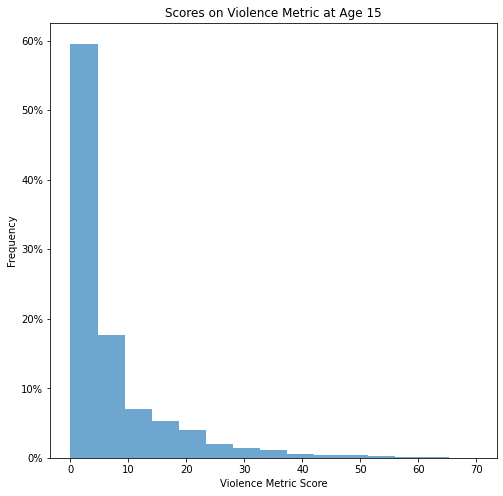

In [ ]:
#Create plot using matplotlib
fig, ax = plt.subplots(figsize=(8,8))
df.total.hist(ax=ax, weights=100 * np.ones(len(df.total)) / len(df.total), 
              alpha = 0.65, bins = 15)
ax.set(xlabel='Violence Metric Score', ylabel='Frequency', title='Scores on Violence Metric at Age 15')

# Format for y axis ticks, e.g. '40%'
fmt = '%.0f%%' 
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.grid(False)
plt.show()

The first bar accounts for violence scores between 0 and 5 but, based off our scoring system, the minimum total violence score for a person was 6 if they demonstrated a violent tendency in any question. Thus, the first bar really represents scores of 0. It appears that nearly 60% of kids have violence scores of 0 which is a good sign for humanity. Another nearly 20% have scores between 5 and 10 (meaning they demonstrated a violent tendency in just one question). This leaves the remaining 20% with violence scores over 10. 

Next, let's make a scatterplot of Violence Score and Mother's Household Income/Porverty Ratio. Intuitively, we would assume that people growing up in lower income areas might have weaker support systems and be more liekly to turn to violence.

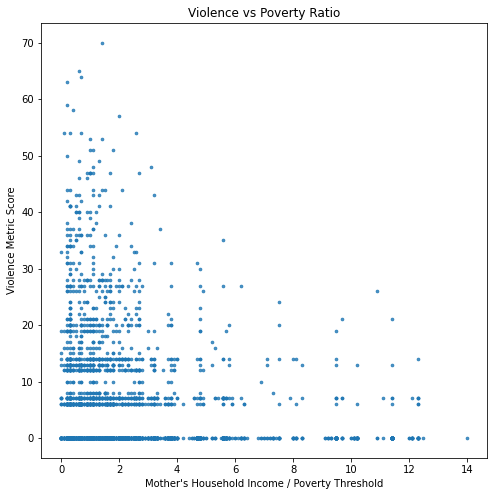

In [ ]:
#Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df.cm1inpov, df.total, s=7, alpha=.8)
ax.set(xlabel='Mother\'s Household Income / Poverty Threshold', ylabel='Violence Metric Score', title='Violence vs Poverty Ratio')
ax.grid(False)

Interesting! There appears to be a negative glance at first trend, as we suspected. Let's run a simple regression with these variables to see how strong this relationship is.

In [ ]:
#We use the ols package from statsmodels to run a regression

model = ols("total ~ cm1inpov", data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     107.7
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           7.81e-25
Time:                        20:18:18   Log-Likelihood:                -11795.
No. Observations:                3205   AIC:                         2.359e+04
Df Residuals:                    3203   BIC:                         2.361e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4748      0.232     32.272      0.0

The coefficient on Mother's Household Income/Poverty Ratio (cm1inpov) is negative, as we thought. The magnitude of -0.7016 suggests that, for every additional decrease by one unit in the mother's income/poverty ratio at time of birth, the child's violence score is estimated to decrease by -0.7016. Essentially, as the mother gets poorer, the child is estimated to be more violent. The t statistic is and -10.375 and two-tailed P-value is 0.000, meaning the income/poverty ratio has basic significance even at the 0.001 significance level.

While there is strong significance, the income/poverty does not seem to have super strong explanatory power. The R^2 value is only 0.033, sugessting that only 3.33% of the total variation in violence scores can be explained by the total variation in the mother's household income/poverty ratio. 

Problems complicating the regression model include a limited number of observations with high income/poverty ratios as well as apparent heteroskedacity.

Next, let's look at the relationship between mother's education and child's violence.



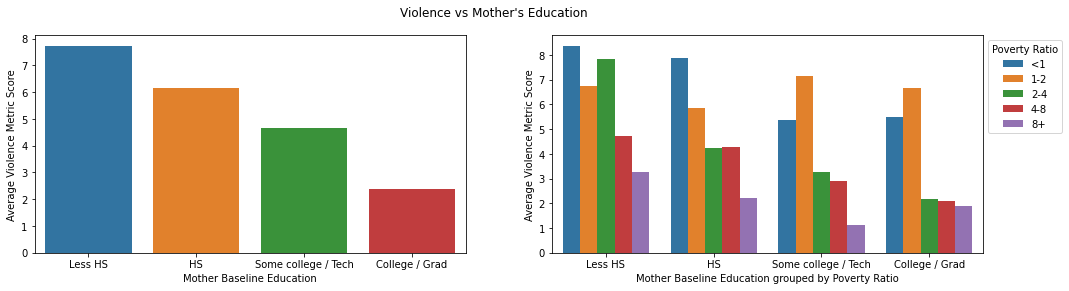

In [ ]:
#Make our plots using seaborn
fig, ax = plt.subplots(1,2, figsize=(17,4))

sns.barplot(x=df.cm1edu, y=df.total, order=['Less HS', 'HS', 'Some college / Tech', 'College / Grad'], ci=None, ax=ax[0])

#For the second plot, group each education level by income/poverty ratio using the hue variable
sns.barplot(x=df.cm1edu, y=df.total, order=['Less HS', 'HS', 'Some college / Tech', 'College / Grad'], hue=df.povlevel, ci=None, ax=ax[1])

#Set titles and formatting
ax[0].set(xlabel = 'Mother Baseline Education', ylabel = 'Average Violence Metric Score')
ax[1].set(xlabel = 'Mother Baseline Education grouped by Poverty Ratio', ylabel = 'Average Violence Metric Score')
plt.suptitle('Violence vs Mother\'s Education')
ax[1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title = "Poverty Ratio")
plt.show()

In the plot on the left, the average violence score clearly seems to be lower for children whose mother's have more education. However, we guess that education level is strongly correlated with income level, which we already determined also has an effect on violence.

In the graph on the right, we break down average violence score by income for each level of education. Violence still seems to generally decrease with more education across income levels, but the trend is less pronounced as before.

Next, let's look at the relationship between father's education and child's violence. We expect we'll see a similar relationship as with mother's education

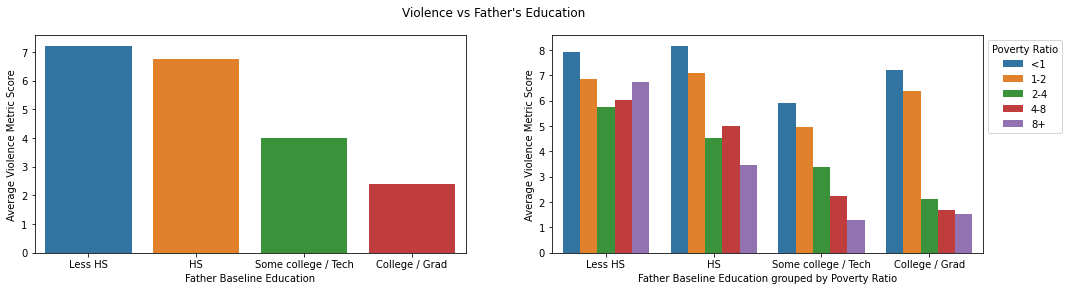

In [ ]:
#Make our plots using seaborn

fig, ax = plt.subplots(1,2, figsize=(17,4))
sns.barplot(x=df.cf1edu, y=df.total, order=['Less HS', 'HS', 'Some college / Tech', 'College / Grad'], ci=None, ax=ax[0])
sns.barplot(x=df.cf1edu, y=df.total, order=['Less HS', 'HS', 'Some college / Tech', 'College / Grad'], hue=df.povlevel, ci=None, ax=ax[1])
ax[0].set(xlabel = 'Father Baseline Education', ylabel = 'Average Violence Metric Score')
ax[1].set(xlabel = 'Father Baseline Education grouped by Poverty Ratio', ylabel = 'Average Violence Metric Score')
plt.suptitle('Violence vs Father\'s Education')
ax[1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title = "Poverty Ratio")
plt.show()

As expected we see a similar relationship as we did with mother's education for both graphs. This makes intuitive sense. We should also note that mother's education and father's education are likely highly correlated with each other.

In the next few graphs we'll look at the relationship between substance consumption during pregnancy and violence. We might see a possible relationship for two reasons. For one, using substances during pregnancy likely indicates that a parent does not prioritize the child and may not provide strong behavioral support in the future. In addition, some substance use has the potential to cause mental birth defects which could translate into more violent tendencies as well.

First, we'll graph alcohol consumption during pregnancy and violence scores.


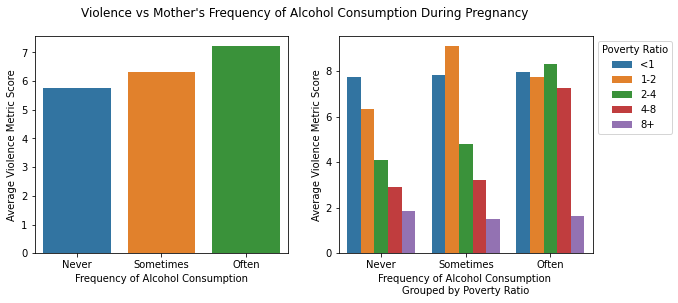

In [ ]:
#Make our plots using seaborn

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(x=df.m1g2, y=df.total, order=['Never', 'Sometimes', 'Often'], ci=None, ax=ax[0])
sns.barplot(x=df.m1g2, y=df.total, order=['Never', 'Sometimes', 'Often'], hue=df.povlevel, ci=None, ax=ax[1])
ax[0].set(xlabel = 'Frequency of Alcohol Consumption', ylabel = 'Average Violence Metric Score')
ax[1].set(xlabel = 'Frequency of Alcohol Consumption \nGrouped by Poverty Ratio', ylabel = 'Average Violence Metric Score')
plt.suptitle('Violence vs Mother\'s Frequency of Alcohol Consumption During Pregnancy')
ax[1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title = "Poverty Ratio")
plt.show()

We see that the average violence score increases with more alcohol consumption. When we group by poverty ratio, this effect appears to go away for the poorest and wealthiest families but still occur in middle income families.

Next we'll graph drug use during pregnancy and violence score.




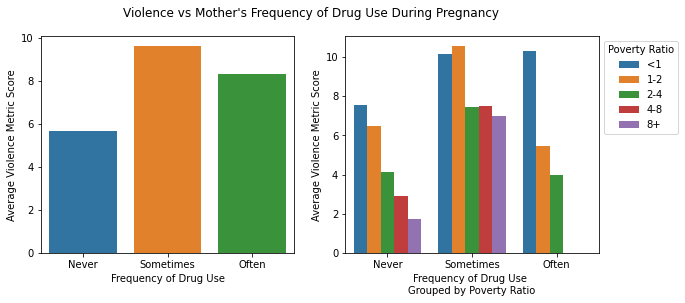

In [ ]:
#Make our plots using seaborn

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(x=df.m1g3, y=df.total, order=['Never', 'Sometimes', 'Often'], ci=None, ax=ax[0])
sns.barplot(x=df.m1g3, y=df.total, order=['Never', 'Sometimes', 'Often'], hue=df.povlevel, ci=None, ax=ax[1])
ax[0].set(xlabel = 'Frequency of Drug Use', ylabel = 'Average Violence Metric Score')
ax[1].set(xlabel = 'Frequency of Drug Use \nGrouped by Poverty Ratio', ylabel = 'Average Violence Metric Score')
plt.suptitle('Violence vs Mother\'s Frequency of Drug Use During Pregnancy')
ax[1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title = "Poverty Ratio")
plt.show()

It appears that the children of drug users during pregnancy have generally higher violence scores, but this effect is somewhat inconsistent.

Finally, we'll graph cigarette use during pregnancy and violence score.



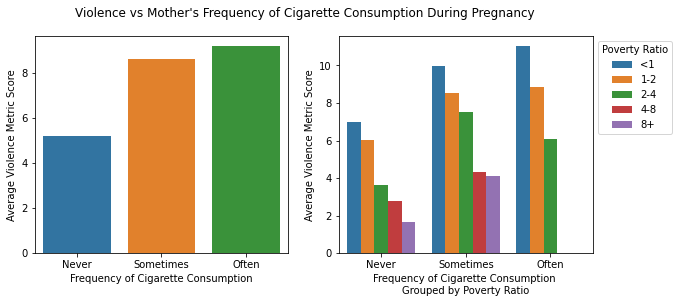

In [ ]:
#Make our plots using seaborn

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(x=df.m1g4, y=df.total, order=['Never', 'Sometimes', 'Often'], ci=None, ax=ax[0])
sns.barplot(x=df.m1g4, y=df.total, order=['Never', 'Sometimes', 'Often'], hue=df.povlevel, ci=None, ax=ax[1])
ax[0].set(xlabel = 'Frequency of Cigarette Consumption', ylabel = 'Average Violence Metric Score')
ax[1].set(xlabel = 'Frequency of Cigarette Consumption \nGrouped by Poverty Ratio', ylabel = 'Average Violence Metric Score')
plt.suptitle('Violence vs Mother\'s Frequency of Cigarette Consumption During Pregnancy')
ax[1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title = "Poverty Ratio")
plt.show()

Here, we see a similar distribution as with alcohol use. This relationship appears to be clearer then drug use.

Unfortunately, these graphs can only tell us so much as we have relatively limited observations (thankfully for humanity) of cigarette and alcohol users during pregancy. We have enough observations to see some trends, but it is important to be cautious when drawing conclusions.

Now let's see whether there is a correlation between the father being in jail during the time of birth with violent outcomes.

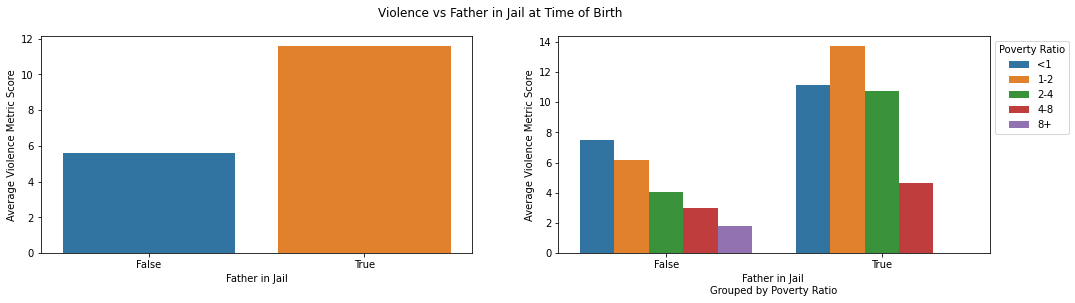

In [ ]:
#Make our plots using seaborn
fig, ax = plt.subplots(1,2, figsize=(17,4))
sns.barplot(x=df.cm1ffinjail, y=df.total, ci=None, ax=ax[0])
sns.barplot(x=df.cm1ffinjail, y=df.total, ci=None, hue=df.povlevel, ax=ax[1])
ax[0].set(xlabel = 'Father in Jail', ylabel = 'Average Violence Metric Score')
ax[1].set(xlabel = 'Father in Jail \nGrouped by Poverty Ratio', ylabel = 'Average Violence Metric Score')
plt.suptitle('Violence vs Father in Jail at Time of Birth')
ax[1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title = "Poverty Ratio")
plt.show()

There is a disparity in violence in youths whose fathers were in jail during their births. Although this increase could be tied to a number of external factors, the correlation is clear. This trend holds true even when we group by poverty ratio.

Let's switch gears a bit. We'll look at the average violence metric score across different the relationship statuses of the childs parents' at the time of birth.

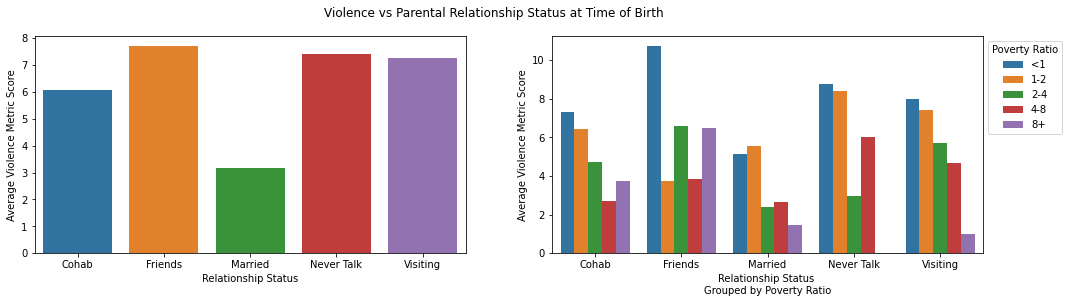

In [ ]:
#Make our plots using seaborn
fig, ax = plt.subplots(1,2, figsize=(17,4))
sns.barplot(x=df.cm1relf, y=df.total, ci=None, ax=ax[0])
sns.barplot(x=df.cm1relf, y=df.total, ci=None, hue=df.povlevel, ax=ax[1])
ax[0].set(xlabel = 'Relationship Status', ylabel = 'Average Violence Metric Score')
ax[1].set(xlabel = 'Relationship Status \nGrouped by Poverty Ratio', ylabel = 'Average Violence Metric Score')
plt.suptitle('Violence vs Parental Relationship Status at Time of Birth')
ax[1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title = "Poverty Ratio")
plt.show()

Wow! Relationship status of parents at time of birth seems to have a big impact. The average violence score among children whose parents were married at birth is twice as low as the average violence scores among children whose parents were only friends, visiting, or never talking at time of birth.

This stark difference is lessened somehwat when controlled for income, but the average "Married" violence score is still roughly 4 points lower than the average violence score for "Never Talk". Married parents are less likely to have children that end up being violent even if they are low income

One more graph to explore! Let's see how average violence score compares across religions

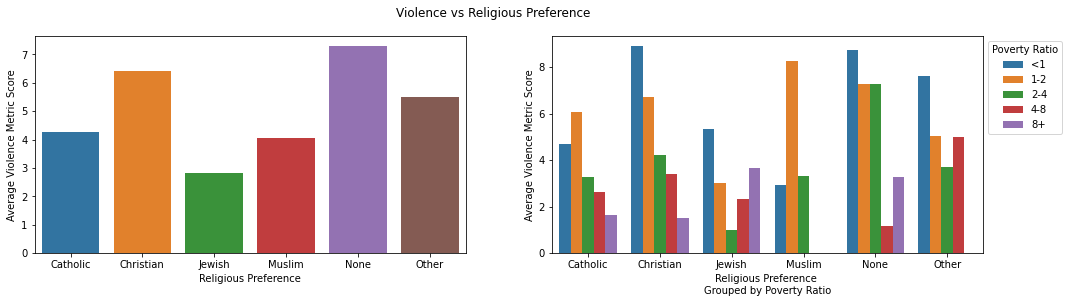

In [ ]:
#Create plots using seaborn

fig, ax = plt.subplots(1,2, figsize=(17,4))
sns.barplot(x=df.m1f7, y=df.total, ci=None, ax=ax[0])
sns.barplot(x=df.m1f7, y=df.total, ci=None, hue=df.povlevel, ax=ax[1])
ax[0].set(xlabel = 'Religious Preference', ylabel = 'Average Violence Metric Score')
ax[1].set(xlabel = 'Religious Preference \nGrouped by Poverty Ratio', ylabel = 'Average Violence Metric Score')
plt.suptitle('Violence vs Religious Preference')
ax[1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title = "Poverty Ratio")
plt.show()

There were limited observations for religions other than Catholic, Christian, and None, so it is difficult to place too much weight on the above graph. Still, there appears to be some variation among religions. For the most part, this variation holds when income is taken into account. The average violence scores for those with no religion and for Christians is notably higher than the average scores for the other groups.

###<u>**Machine Learning**</u>

Now that we have explored several aspects of our data, we turn to a more ambitious task. Is it possible to predict violence in teenage years, solely based off of survey questions conducted at birth? We begin machine learning to find out!

First, we prepare the features and target for machine learning by cleaning the predictive features (survey questions), and separating the target (binned score on the violence metric).

In [ ]:
#We drop the idnum of each family, as well as targets we are predicting from the training set
X = df.drop(columns=['idnum','p6b35', 'p6b37', 'p6b41', 'p6b42', 'p6b45', 'k6d61d', 'k6d61i', 'k6d61l','total','total_bins','povlevel'])

#Use dummies for categorical features
X = pd.get_dummies(data = X, columns=['cm1relf','m1g2','m1f3','m1g3','m1g4','cm1edu','cf1edu','cm1ffinjail','m1f7'])
y = df.loc[:,'total_bins']

#Create a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = True, random_state = 8)

The first algorithm we will try is the Random Forest algorithm. We run grid search on the training set to find optimal hyperparameters.

In [ ]:
#Dictionary of hyperparameters
rf_parameters = {
    'n_estimators': [100,200,300,400,500,600],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [5,10,15,20],
    'criterion' :['gini', 'entropy'],
}

#Run gridsearch
rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_parameters, cv= 5)

#fit the model
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500, 600]})

GridSearchCV outputs the best parameters. Let's examine them!

In [ ]:
rf_cv.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'log2',
 'n_estimators': 300}

Next we use these hyperparameters to evaluate the efficacy of the model. We run 10 fold cross validation to make the most of the data available to us.

In [ ]:
#Create optimized random forest classifier
rf_clf = RandomForestClassifier(n_estimators = rf_cv.best_params_['n_estimators'], criterion=rf_cv.best_params_['criterion'], 
                                max_depth=rf_cv.best_params_['max_depth'], max_features=rf_cv.best_params_['max_features']) 

#Run 10 fold cross validation
rf_scores = model_selection.cross_val_score(rf_clf, X_train, y_train, cv=10)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Although Random Forest is an efficient and powerful algorithm, it would be useful to compare its performance to a simpler algorithm, K Nearest Neighbors. We thus repeat the process from above using KNN.

In [ ]:
# defining parameter range
k_range = list(range(1, 30))
grid = dict(n_neighbors=k_range)
  
# fitting the model for grid search
knn_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=grid, cv=5)

knn_cv.fit(X_train, y_train)

In [ ]:
# Output the best number of neighbors to use
knn_cv.best_params_

In [ ]:
# creating a KNN classifier with the hyperparameters found using gridsearch
knn_clf = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors']) 

# Run 10-fold cross validation
knn_scores = model_selection.cross_val_score(knn_clf, X_train, y_train, cv=10)

Let's visualize the difference in scores between the Random Forest and KNN algorithms.

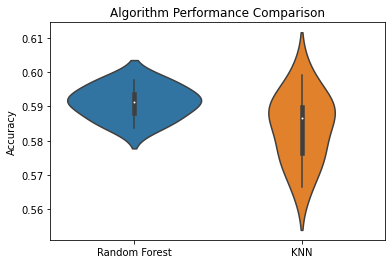

In [ ]:
scores = pd.DataFrame({'Random Forest': rf_scores, 'KNN': knn_scores})
ax = sns.violinplot(data=scores)
ax.set(ylabel = 'Accuracy', title = 'Algorithm Performance Comparison')
plt.show()

As we can see in the violinplot, the Random Forest Algorithm results in a slightly higher mean accuracy, and smaller standard deviation. Are these results statistically significant however?

In [ ]:
print(f'T test p-value for whether mean accuracy is different between RF and KNN: {stats.ttest_ind(rf_scores, knn_scores).pvalue}')

T test p-value for whether mean accuracy is different between RF and KNN: 0.04547800983616254


In [ ]:
def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = group1.size-1
    dun = group2.size-1
    p_value = 1-stats.f.cdf(f, nun, dun)
    return p_value
  
# perform F-test
f = f_test(rf_scores, knn_scores)
print(f'F test p-value for whether standard deviation is different between RF and KNN: {f}')

F test p-value for whether standard deviation is different between RF and KNN: 0.9819901180141816


The T test shows that the difference in algorithm performances is in fact not significant.

We originally segmented 20% of the data for holdout validation. Let's use it now to compare algorithm performances!

In [ ]:
#Now I use the test dataset to compare accuracy
rf_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_test)
knn_y_pred = knn_clf.predict(X_test)

# using metrics module for accuracy
rf_accuracy = metrics.accuracy_score(y_test, rf_y_pred)
knn_accuracy = metrics.accuracy_score(y_test, knn_y_pred)

print(f'Random Forest Accuracy on Test Set: {rf_accuracy}')
print(f'K Nearest Neighbors Accuracy on Test Set: {knn_accuracy}')

Random Forest Accuracy on Test Set: 0.6209048361934477
K Nearest Neighbors Accuracy on Test Set: 0.6224648985959438


We again found similar performace between the algorithms.

###<u>**Analysis of Models**</u>

At first glance, it may appear that our models are performing relatively well. We are achieving roughly 60% accuracy for classification into 5 bins, which is much better than random classification, which would result in 20% accuracy. However, upon further reflection, we must note that roughly 80% of our data consisted of individuals who scored a 0 on the violence metric, placing them into the first bin. Therefore an algorithm that simply classified everyone as non-violent would have achieved a higher accuracy overall. For future work, we recommend compensating for the skewed distribution of the dataset. One approach would be to duplicate the data in the sparser classes. Another is to synthetically create data.

###<u>**Conclusions**</u>
Even with a dataset as rich as the Fragile Families study, it was difficult to generate insights about predictors of child violence. Through hypothesis testing, we found that mother’s household income/poverty is highly significant in predicting a child’s violence score. We also identified a few additional risk factors- a less educated mother, alcohol/cigarette use by the mother during pregnancy, and a limited relationship between the baby’s parents- which all appear to be associated with higher average violence scores. We found that these trends generally hold even when poverty level is accounted for. 

It is important to note that our created violence metric was arbitrary. It is possible that, if we had calculated our violence score differently, we would have come to different conclusions. 

Despite finding associations during our exploratory data analysis which supported our intuition, our machine learning models failed to translate these into strong predictive power. While the survey questions we used provide meaningful insight into violent behavior in the aggregate, it appears they do not provide enough information to predict well how violent a child will be on an individual level. This is disappointing in terms of our project, but perhaps not surprising. A child’s tendency to be violent at age 15 is the result of a complex development process unfolding over a decade and a half, filled with many variables that cannot be predicted solely from their family at birth. In fact, it is probably good for humanity’s sense of free will that one’s future pattern of violence cannot be effectively predetermined at birth.


###<u>**Resources**</u>

[How To Perform an F Test](https://www.geeksforgeeks.org/how-to-perform-an-f-test-in-python/)

[Seaborn Library](https://seaborn.pydata.org/)

[Extracting SAS Files](https://pypi.org/project/sas7bdat/)

[Pandas](https://pandas.pydata.org/)

[MatPlotLib](https://matplotlib.org/)

[StatsModels](https://www.statsmodels.org/)

[Machine Learning](https://scikit-learn.org/stable/)

[Fragile Families Data](https://fragilefamilies.princeton.edu/data-and-documentation/public-data-documentation)

The Fragile Families study requires us to provide the following statement: 
Research reported in this publication was supported by the Eunice Kennedy Shriver National Institute of Child Health and Human Development (NICHD) of the National Institutes of Health under award numbers R01HD036916, R01HD039135, and R01HD040421, as well as a consortium of private foundations. The content is solely the responsibility of the authors and does not necessarily represent the official views of the National Institutes of Health.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Final_Draft.ipynb


[NbConvertApp] Converting notebook /content/Final_Draft.ipynb to html
[NbConvertApp] Writing 694813 bytes to /content/Final_Draft.html
